In [1]:
print('hello world')

hello world


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240413_113323


In [4]:
# !python preprocess.py --data_root data/TOPKIDS/ --no_normalize --no_dist --n_eig 200

In [4]:
# data_x = test_set[15]['first']
# data_y = test_set[15]['second']

# get 15th element from test dataloader
for i, data in enumerate(test_loader):
    if i == 5:
        data_x = data['first']
        data_y = data['second']
        break

list(data_x.keys())

['name',
 'verts',
 'faces',
 'evecs',
 'evecs_trans',
 'evals',
 'mass',
 'L',
 'corr']

In [5]:
print('data_x', data_x['name'], 'data_y', data_y['name'])

Pxy = -torch.ones(data_x['verts'].shape[1], dtype=torch.int64)
print('Pxy.shape', Pxy.shape)
Pxy[data_x['corr']] = data_y['corr']

Pyx = -torch.ones(data_y['verts'].shape[1], dtype=torch.int64)
print('Pyx.shape', Pyx.shape)
Pyx[data_y['corr']] = data_x['corr']

# check 
range_1_len = torch.arange(data_x['verts'].shape[1])
print('Pxy', Pxy[:20])
print('Pyx', Pyx[:20])
print(torch.cat((range_1_len.view(-1, 1), Pxy.view(-1, 1)), dim=1)[:20])

data_x ['tr_reg_080'] data_y ['tr_reg_085']
Pxy.shape torch.Size([5000])
Pyx.shape torch.Size([5000])
Pxy tensor([  71,   72,    7,    2,   -1,   -1,    3,   56, 1628,    8, 1806,  157,
          45,   14,  158,   16,  148,   19,   46,   21])
Pyx tensor([ 25,   1,   3,   6,  -1, 138,   6,   2,   9, 968, 967,  -1,  11,  41,
         13,  90,  15, 131,  36,  37])
tensor([[   0,   71],
        [   1,   72],
        [   2,    7],
        [   3,    2],
        [   4,   -1],
        [   5,   -1],
        [   6,    3],
        [   7,   56],
        [   8, 1628],
        [   9,    8],
        [  10, 1806],
        [  11,  157],
        [  12,   45],
        [  13,   14],
        [  14,  158],
        [  15,   16],
        [  16,  148],
        [  17,   19],
        [  18,   46],
        [  19,   21]])


In [6]:
# print number of unique elements in Pxy and count of each element, sorted by count
unique, counts = Pxy.unique(return_counts=True)

# print the values sorted by count
print('unique', unique[torch.argsort(counts, descending=True)])
print('counts', counts[torch.argsort(counts, descending=True)])

unique tensor([  -1, 1616, 1290,  ..., 1766, 1768, 1769])
counts tensor([1538,    3,    3,  ...,    1,    1,    1])


In [7]:
import trimesh

scene = trimesh.Scene()

# Are raw meshes aligned?

In [8]:
import trimesh
import numpy as np

# clear the scene
scene.geometry.clear()

# cmap = trimesh.visual.color.interpolate(np.linspace(0, 1, len(data_y['verts'][0])), 'jet')

# make a color map based on y coordinate
cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 1], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

print('distance between vertices in dataset and vertices in mesh object:',
      (data_x['verts'][0].numpy() - mesh1.vertices).sum()
      )

# display the scene
scene.show('notebook')

distance between vertices in dataset and vertices in mesh object: 0.0


# After applying correspondences

In [9]:
def index_with_P(tensor_to_index, P):
    # assert tensor_to_index.shape[0] == P.shape[0], f'tensor_to_index.shape {tensor_to_index.shape} != P.shape {P.shape}'
    
    indexed_tensor = tensor_to_index[P]
    
    # replace values where P = -1 with zeros
    if type(indexed_tensor) == torch.Tensor:
        backend = torch 
    elif type(indexed_tensor) == np.ndarray:
        backend = np
    else:
        raise ValueError(f'Unknown type of indexed_tensor {type(indexed_tensor)}')
    
    indexed_tensor[P == -1] = backend.zeros_like(indexed_tensor[P == -1])
    return indexed_tensor
    

# X -> Y


In [10]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 1], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)



mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())

# cmap2 = cmap[Pyx][:len(mesh2.vertices)]
cmap2 = index_with_P(cmap, Pyx)[:len(mesh2.vertices)]
print(cmap2.shape, len(mesh2.vertices))

mesh2.visual.vertex_colors = cmap2
scene.add_geometry(mesh2)

scene.show()

(4999, 4) 4999


# Y -> X

In [11]:
#########################################
# Y -> X
#########################################

scene.geometry.clear()

cmap2 = trimesh.visual.color.interpolate(data_y['verts'][0][:, 1], 'hsv')


# add the second mesh
mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
cmap = index_with_P(cmap2, Pxy)
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)

scene.show()

# Are eigenfunctions orthogonal?

In [12]:
phi_T_phi = data_x['evecs_trans'][0] @ data_x['evecs'][0]
phi_phi_T = data_x['evecs'][0] @ data_x['evecs_trans'][0]

print('phi.shape', data_x['evecs'][0].shape)
print('phi_T_phi.shape:', phi_T_phi.shape, ', dist(phi_T @ phi, I):', (phi_T_phi - torch.eye(phi_T_phi.shape[0])).abs().sum())
print('phi_phi_T.shape:', phi_phi_T.shape, ', dist(phi @ phi_T, I):', (phi_phi_T - torch.eye(phi_phi_T.shape[0])).abs().sum())

phi.shape torch.Size([5000, 200])
phi_T_phi.shape: torch.Size([200, 200]) , dist(phi_T @ phi, I): tensor(0.0004)
phi_phi_T.shape: torch.Size([5000, 5000]) , dist(phi @ phi_T, I): tensor(25861.1484)


# Calculate the functional map

In [13]:
phi_x = data_x['evecs'][0]
phi_x_T = data_x['evecs_trans'][0]
phi_y = data_y['evecs'][0]
phi_y_T = data_y['evecs_trans'][0]

Cxy = phi_y_T @ index_with_P(phi_x, Pyx)
Cyx = phi_x_T @ index_with_P(phi_y, Pxy)

# print('index_with_P(phi_x, Pyx).shape', index_with_P(phi_x, Pyx).shape)
# print('index_with_P(phi_x, Pyx)', index_with_P(phi_x, Pyx)[:10])

# print('Cxy.shape', Cxy.shape)
# print('Cxy', Cxy[:10])

# print('Cyx.shape', Cyx.shape)
# print('Cyx', Cyx[:10])

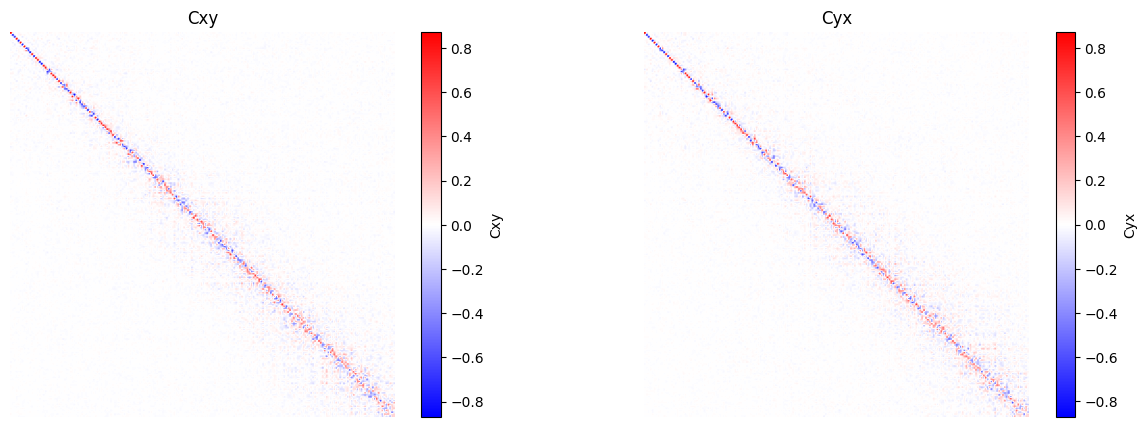

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Cxy
Cxy_plot = ax[0].imshow(Cxy.cpu().numpy(), cmap='bwr')
ax[0].axis('off')
ax[0].set_title('Cxy')
cbar = plt.colorbar(Cxy_plot)
cbar.set_label('Cxy')

# Cyx
Cyx_plot = ax[1].imshow(Cyx.cpu().numpy(), cmap='bwr')
ax[1].axis('off')
ax[1].set_title('Cyx')
cbar = plt.colorbar(Cyx_plot)
cbar.set_label('Cyx')

plt.show()

# Check for orthogonality

In [18]:
print('dist(Cyx @ Cxy, I)', ((Cyx @ Cxy) - torch.eye(Cxy.shape[0])).abs().sum())
print('dist(Cxy @ Cyx, I)', ((Cxy @ Cyx) - torch.eye(Cxy.shape[0])).abs().sum())
print('dist(Cxy @ Cxy.T, I)', ((Cxy @ Cxy.T) - torch.eye(Cxy.shape[0])).abs().sum())
print('dist(Cyx @ Cyx.T, I)', ((Cyx @ Cyx.T) - torch.eye(Cxy.shape[0])).abs().sum())

dist(Cyx @ Cxy, I) tensor(514.0875)
dist(Cxy @ Cyx, I) tensor(523.1017)

dist(Cxy @ Cxy.T, I) tensor(550.4919)
dist(Cyx @ Cyx.T, I) tensor(566.3071)


# Another method

dist(Cxy, C_gt_xy): tensor(0.)
dist(Cyx, C_gt_yx): tensor(0.)
dist(C_gt_xy @ C_gt_xy_T, I): tensor(262.8440)
dist(C_gt_yx @ C_gt_yx_T, I): tensor(268.9554)
dist(C_gt_xy @ C_gt_yx, I): tensor(129.5207)
dist(C_gt_yx @ C_gt_xy, I): tensor(136.8091)


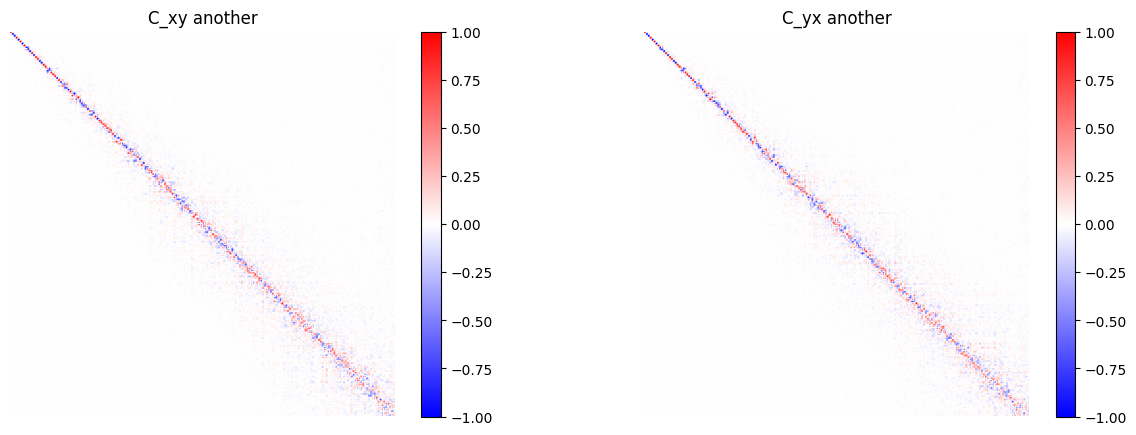

In [42]:
C_gt_xy = (torch.pinverse(phi_y[data_y['corr']]) @ phi_x[data_x['corr']])[0]
C_gt_yx = (torch.pinverse(phi_x[data_x['corr']]) @ phi_y[data_y['corr']])[0]

# calculate distance to Cxy and Cyx
print('dist(Cxy, C_gt_xy):', (Cxy - C_gt_xy).abs().sum())
print('dist(Cyx, C_gt_yx):', (Cyx - C_gt_yx).abs().sum())

# check orthogonality for C_gt_xy and C_gt_yx
print('dist(C_gt_xy @ C_gt_xy_T, I):', (C_gt_xy @ C_gt_xy.T - torch.eye(C_gt_xy.shape[0])).abs().sum())
print('dist(C_gt_yx @ C_gt_yx_T, I):', (C_gt_yx @ C_gt_yx.T - torch.eye(C_gt_yx.shape[0])).abs().sum())
print('dist(C_gt_xy @ C_gt_yx, I):', (C_gt_xy @ C_gt_yx - torch.eye(C_gt_xy.shape[0])).abs().sum())
print('dist(C_gt_yx @ C_gt_xy, I):', (C_gt_yx @ C_gt_xy - torch.eye(C_gt_yx.shape[0])).abs().sum())

# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# C_gt_xy
C_gt_xy_plot = ax[0].imshow(C_gt_xy.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_xy_plot)
ax[0].axis('off')
ax[0].set_title('C_xy another')

# C_gt_yx
C_gt_yx_plot = ax[1].imshow(C_gt_yx.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_yx_plot)
ax[1].axis('off')
ax[1].set_title('C_yx another')

plt.show()

In [28]:
# use the second method
Cxy = C_gt_xy
Cyx = C_gt_yx

# Get the P2P map back

In [68]:
Pyx_after = phi_y @ Cxy @ phi_x_T
Pxy_after = phi_x @ Cyx @ phi_y_T

In [64]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)


mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())

print(cmap.shape)

cmap2 = Pyx_after @ (cmap.astype(np.float32) / 255)

cmap2 = (torch.abs(cmap2).numpy() * 255).clip(0, 255).astype(np.uint8)
# cmap2[:, 3] = 255

# cmap2 = index_with_P(cmap, Pyx)[:len(mesh2.vertices)]
# print(cmap2.shape, len(mesh2.vertices))

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

scene.show()

(5000, 4)


In [65]:
#########################################
# Y -> X
#########################################

scene.geometry.clear()

cmap2 = trimesh.visual.color.interpolate(data_y['verts'][0][:, 1], 'jet')


# add the second mesh
mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())

cmap = Pxy_after @ (cmap2.astype(np.float32) / 255)
cmap = (torch.abs(cmap).numpy() * 255).clip(0, 255).astype(np.uint8)
cmap2[:, 3] = 255

mesh1.visual.vertex_colors = cmap

scene.add_geometry(mesh1)

scene.show()

# Texture transfer

In [66]:
import utils.texture_util as texture_util

uv1 = texture_util.generate_tex_coords(data_x['verts'][0].cpu().numpy())
uv2_after = Pyx_after @ uv1
uv2_before = index_with_P(uv1, Pyx)

In [67]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

# read /home/s94zalek/shape_matching/figures/texture.png with PIL
from PIL import Image

texture_img = Image.open('/home/s94zalek/shape_matching/figures/texture.png')

# create material
material=trimesh.visual.material.SimpleMaterial(
        image=texture_img,
        diffuse=[255, 255, 255, 255],
    )

texture_visuals = trimesh.visual.texture.TextureVisuals(
    uv=uv1,
    material=material
)

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual = texture_visuals

scene.add_geometry(mesh1)


# correspondence we got from the functional map
mesh2_after = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())

texture_visuals_after = trimesh.visual.texture.TextureVisuals(
    uv=uv2_after[:len(mesh2_after.vertices)],
    material=material
)
mesh2_after.visual = texture_visuals_after

scene.add_geometry(mesh2_after)

scene.show()